<font color="red">

## Задачи:

1. Провести анализ данных общего энергопотребления Калининградской области за период с января 2019 года по конец июля 2023.
2. Установить взаимосвязи между энергопотреблением и погодой.
3. Провести декомпозицию временного ряда для поиска тренда и сезонности.

</font>


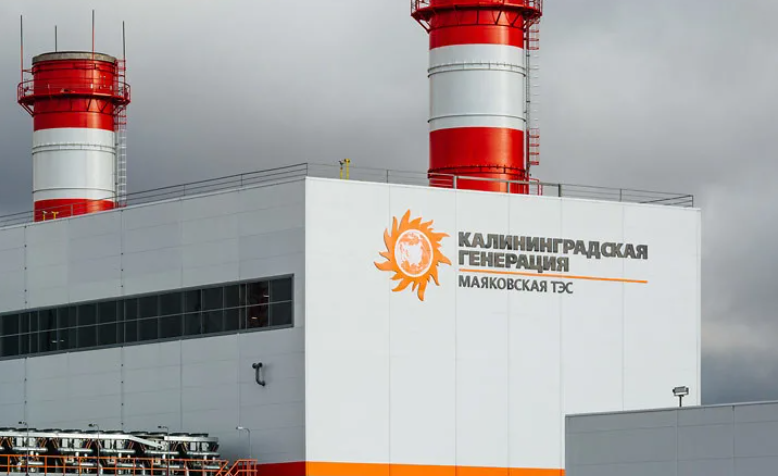

## Загрузка библиотек

In [ ]:
pip install prophet

In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from scipy.stats import ttest_1samp
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet

## Импорт и преобразование данных


In [ ]:
file_path = '/content/drive/My Drive/Университет/Intelligent_analysis/dataset.xls'
df = pd.read_excel(file_path)

print(f"Типы полей в датафрейме: \n{df.dtypes}")
print(f"\nКоличество строк и столбцов в датафрейме: \n{df.shape}")
print(f"\nКоличество пустых значений в каждом столбце: \n{df.isnull().sum()}\n")
df

Типы полей в датафрейме: 
date             object
time              int64
target          float64
temp            float64
temp_pred       float64
weather_pred     object
weather_fact     object
dtype: object

Количество строк и столбцов в датафрейме: 
(40152, 7)

Количество пустых значений в каждом столбце: 
date              0
time              0
target            0
temp              0
temp_pred       112
weather_pred    112
weather_fact      1
dtype: int64



date  time   target  temp  temp_pred     weather_pred  \
0      2019-01-01     0  481.510   2.9        2.0      пасм, ветер   
1      2019-01-01     1  462.872   2.9        2.0      пасм, ветер   
2      2019-01-01     2  449.718   2.9        2.0      пасм, ветер   
3      2019-01-01     3  430.908   4.3        2.0      пасм, ветер   
4      2019-01-01     4  415.163   4.3        2.0      пасм, ветер   
...           ...   ...      ...   ...        ...              ...   
40147  2023-07-31    19  453.173  17.2       18.0  пасм, 24% дождь   
40148  2023-07-31    20  446.287  17.2       18.0  пасм, 24% дождь   
40149  2023-07-31    21  444.373  15.8       17.0  пасм, 24% дождь   
40150  2023-07-31    22  449.078  15.8       17.0  пасм, 24% дождь   
40151  2023-07-31    23  416.078  15.8       17.0  пасм, 24% дождь   

      weather_fact  
0            ветер  
1            ветер  
2            ветер  
3      ветер, пасм  
4      ветер, пасм  
...            ...  
40147        п/обл  
40148        п/обл  
40149        п/обл  
40150        п/обл  
40151        п/обл  

[40152 rows x 7 columns]

In [ ]:
# Преобразуем дату во времянной формат
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# А часы в целочисленный
df['time'] = df['time'].astype(int)

# Добавляем информацию о времени суток из столбца 'time' во столбец "date"
df['date'] = df['date'] + pd.to_timedelta(df['time'], unit='h') + pd.to_timedelta('30 minutes')

print(df.dtypes)
df

date            datetime64[ns]
time                     int64
target                 float64
temp                   float64
temp_pred              float64
weather_pred            object
weather_fact            object
dtype: object


date  time   target  temp  temp_pred     weather_pred  \
0     2019-01-01 00:30:00     0  481.510   2.9        2.0      пасм, ветер   
1     2019-01-01 01:30:00     1  462.872   2.9        2.0      пасм, ветер   
2     2019-01-01 02:30:00     2  449.718   2.9        2.0      пасм, ветер   
3     2019-01-01 03:30:00     3  430.908   4.3        2.0      пасм, ветер   
4     2019-01-01 04:30:00     4  415.163   4.3        2.0      пасм, ветер   
...                   ...   ...      ...   ...        ...              ...   
40147 2023-07-31 19:30:00    19  453.173  17.2       18.0  пасм, 24% дождь   
40148 2023-07-31 20:30:00    20  446.287  17.2       18.0  пасм, 24% дождь   
40149 2023-07-31 21:30:00    21  444.373  15.8       17.0  пасм, 24% дождь   
40150 2023-07-31 22:30:00    22  449.078  15.8       17.0  пасм, 24% дождь   
40151 2023-07-31 23:30:00    23  416.078  15.8       17.0  пасм, 24% дождь   

      weather_fact  
0            ветер  
1            ветер  
2            ветер  
3      ветер, пасм  
4      ветер, пасм  
...            ...  
40147        п/обл  
40148        п/обл  
40149        п/обл  
40150        п/обл  
40151        п/обл  

[40152 rows x 7 columns]

In [ ]:
# Создаём копию дф для часовых ресёчей
df_hour = df.copy()

In [ ]:
# Создаём копию дф для дневных ресёчей
df_day = df.copy()

# Дропаём лишнее для суток поле time, а также текстовые поля, которые не можем агрегировать
columns_to_drop = ['time', 'weather_pred', 'weather_fact']
df_day = df_day.drop(columns=columns_to_drop)

# Группируем данные по дням и выполняем агрегацию
df_day = df_day.groupby(df_day['date'].dt.date).agg({
    'target': 'sum',
    'temp': 'mean',
    'temp_pred': 'mean'
}).reset_index()

df_day

date     target     temp  temp_pred
0     2019-01-01  11126.866   4.8750      4.375
1     2019-01-02  11547.210   1.3500      1.500
2     2019-01-03  12235.564  -1.1625     -1.375
3     2019-01-04  12763.044  -1.5000     -0.125
4     2019-01-05  12735.145   0.9375      1.500
...          ...        ...      ...        ...
1668  2023-07-27   9676.911  16.5875     17.125
1669  2023-07-28   9754.812  15.6750     15.625
1670  2023-07-29   9525.396  18.8625     19.500
1671  2023-07-30   9296.344  18.8250     18.375
1672  2023-07-31   9732.440  17.5500     18.250

[1673 rows x 4 columns]

In [ ]:
# Создаём копию для месячных ресёчей
df_month = df.copy()

# Дропаём лишнее для суток поле time, а также текстовые поля, которые не можем агрегировать
columns_to_drop = ['time', 'weather_pred', 'weather_fact']
df_month = df_month.drop(columns=columns_to_drop)

# Группируем данные по месяцам и выполняем агрегацию
df_month = df_month.groupby(df_month['date'].dt.to_period("M")).agg({
    'target': 'sum',
    'temp': 'mean',
    'temp_pred': 'mean'
}).reset_index()

print(df_month.dtypes)
df_month.head()

date         period[M]
target         float64
temp           float64
temp_pred      float64
dtype: object


date      target       temp  temp_pred
0  2019-01  425395.512  -1.802419  -1.862903
1  2019-02  369286.536   2.670089   2.571429
2  2019-03  385135.730   4.628226   4.883065
3  2019-04  329267.425   9.234583   8.675000
4  2019-05  308229.309  12.137097  11.947581

## Изучение характера основного временного ряда


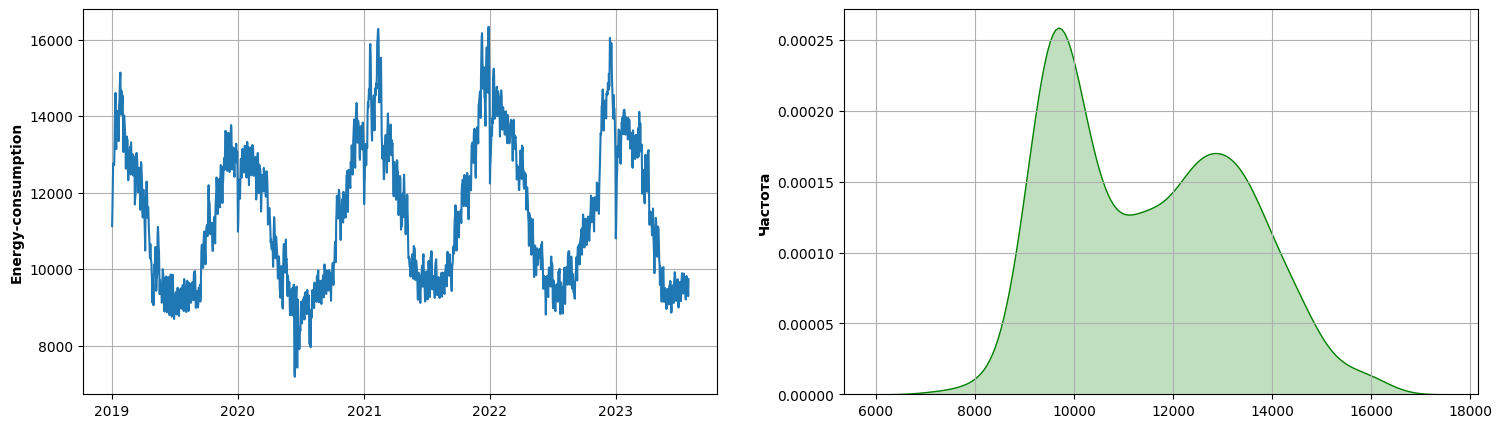

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].plot(df_day.date, df_day.target)
axes[0].grid(True)
axes[0].set_xlabel('')
axes[0].set_ylabel('Energy-consumption', fontweight='bold')

sns.kdeplot(df_day['target'], ax=axes[1], color='green', fill=True)
axes[1].grid(True)
axes[1].set_xlabel('')
axes[1].set_ylabel('Частота', fontweight='bold')
plt.show()

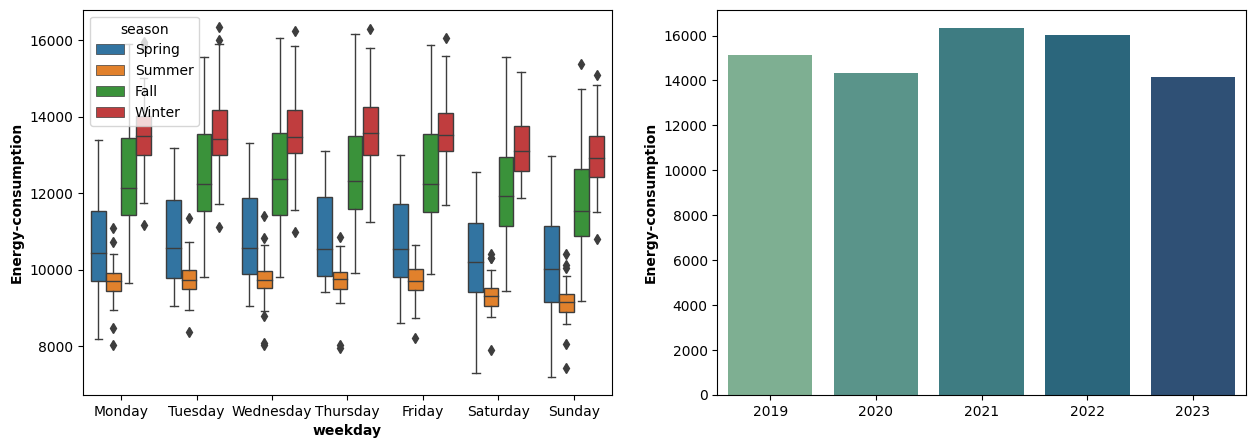

In [ ]:
def create_features(data_full, col_date):
    data = data_full.copy()
    data['weekday'] = data[col_date].dt.day_name().astype(cat_type)
    data['quarter'] = data[col_date].dt.quarter
    data['month'] = data[col_date].dt.month
    data['year'] = data[col_date].dt.year
    data['date_offset'] = (data[col_date].dt.month * 100 + data[col_date].dt.day - 320) % 1300
    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    return data

df_day['date'] = pd.to_datetime(df_day['date'])

cat_type = pd.CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

df_features = create_features(data_full=df_day, col_date='date')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df_features,
            x='weekday',
            y='target',
            hue='season',
            ax=axes[0],
            linewidth=1)
axes[0].set_xlabel('weekday', fontweight='bold')
axes[0].set_ylabel('Energy-consumption', fontweight='bold')

yearAggregated = pd.DataFrame(df_features.groupby("year")["target"].max()).reset_index().sort_values('target')
sns.barplot(data=yearAggregated, x="year", y="target", palette='crest', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Energy-consumption', fontweight='bold')

plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxtyj99_o/dcc7j1t1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxtyj99_o/ipi0q_s4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86883', 'data', 'file=/tmp/tmpxtyj99_o/dcc7j1t1.json', 'init=/tmp/tmpxtyj99_o/ipi0q_s4.json', 'output', 'file=/tmp/tmpxtyj99_o/prophet_modelhl99nk1l/prophet_model-20240106163859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


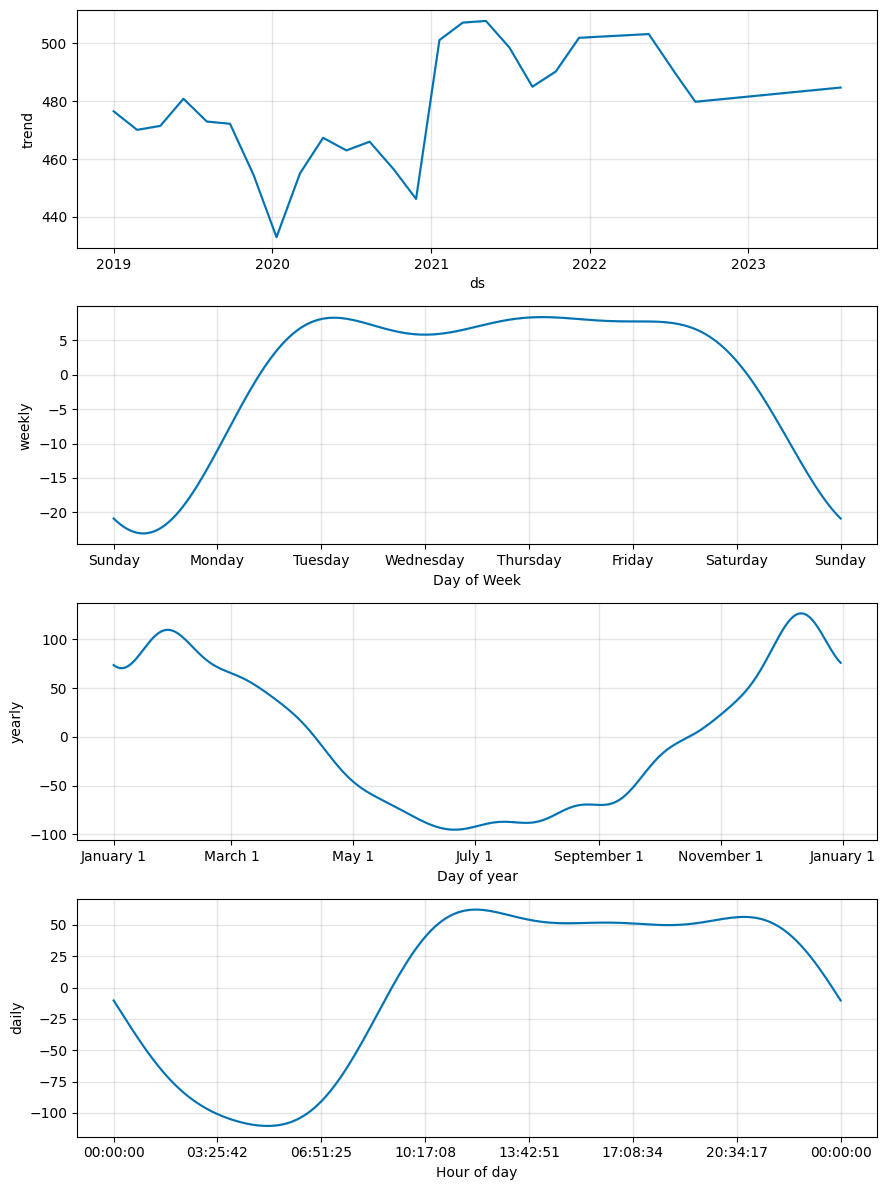

In [ ]:
df_hour_prophet = df_hour.copy()
columns_to_drop = ['temp', 'temp_pred']
df_hour_prophet = df_hour_prophet.drop(columns=columns_to_drop)

df_hour_prophet = df_hour_prophet.rename(columns={'date': 'ds', 'target': 'y'})
model = Prophet()
model.fit(df_hour_prophet)
predict = model.predict(df_hour_prophet)

# Разложение временного ряда на компоненты
fig = model.plot_components(predict)
plt.show()

## Изучение общих взаимосвязей

<Axes: >

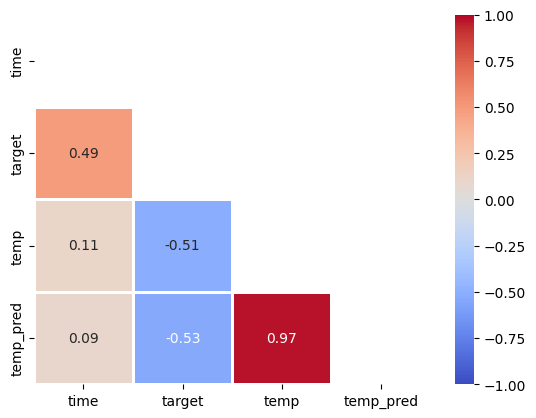

In [ ]:
columns = ['time', 'target', 'temp',	'temp_pred']
df_hour_matrix = df_hour[columns]
upp_mat = np.triu(df_hour_matrix.corr())
sns.heatmap(df_hour_matrix.corr(), vmin=-1, vmax=1, cmap='coolwarm', linewidths=1, linecolor='white', mask=upp_mat, annot=True, fmt='.2f')

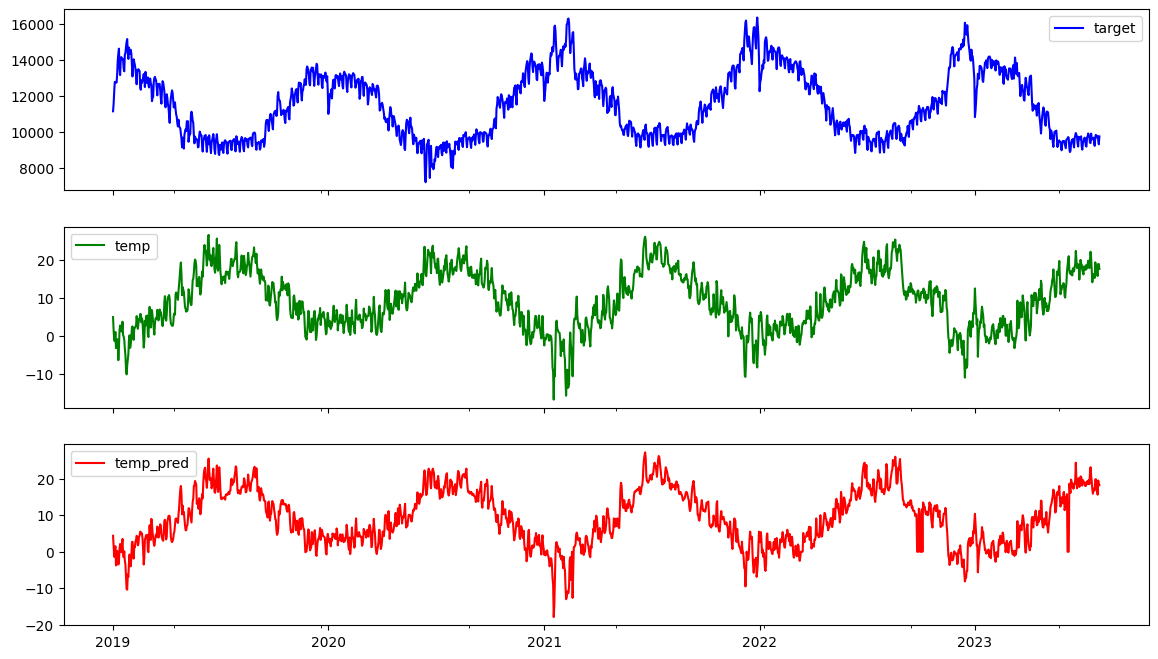

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
df_day.plot(x='date', y='target', ax=axes[0], label='target', color='blue')
df_day.plot(x='date', y='temp', ax=axes[1], label='temp', color='green')
df_day.plot(x='date', y='temp_pred', ax=axes[2], label='temp_pred', color='red')

for ax in axes:
    ax.set_xlabel('')
    ax.legend()

plt.show()

## Изучение характера энергопотребления

### По месяцам

In [ ]:
df_month['date'] = df_month['date'].astype(str)  # Преобразуем объекты Period в строки а то что-то график не рисуется в плотли

fig = px.line(df_month, x='date', y='target')
fig.update_layout(title_text='Потребление электроэнергии по месяцам', title_x=0.5)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='МВт*ч')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### По суткам

In [ ]:
fig.update_xaxes(rangeslider_visible=True)
fig = px.line(df_day, x='date', y='target')
fig.update_layout(title_text='Потребление электроэнергии по дням', title_x=0.5)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='МВт*ч')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### По часам

In [ ]:
fig = px.line(df_hour, x='date', y='target')
fig.update_layout(title_text='Потребление электроэнергии по часам', title_x=0.5)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='МВт*ч')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Изучение характера погоды

### По суткам

In [ ]:
fig = px.line(df_day, x='date', y=['temp', 'temp_pred'],
              labels={'value': 'Значение', 'variable': ''},
              color_discrete_map={'temp': 'green', 'temp_pred': 'red'})

fig.update_layout(
    xaxis_title="",
    yaxis_title="Температура °С",
    legend=dict(yanchor="top", y=1.15, xanchor="left", x=0.85)
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### По часам

In [ ]:
fig = px.line(df_hour, x='date', y=['temp', 'temp_pred'],
              labels={'value': 'Значение', 'variable': ''},
              color_discrete_map={'temp': 'green', 'temp_pred': 'red'})

fig.update_layout(
    xaxis_title="",
    yaxis_title="Температура °С",
    legend=dict(yanchor="top", y=1.15, xanchor="left", x=0.85)
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Метрики качество предсказания погоды

In [ ]:
# Почистим строки с пропусками в прогнозе погоды - на датасет из 40к строк их было около 100
df_hour_temp = df_hour.copy()
df_hour_temp = df_hour_temp.dropna(subset=['temp_pred'])

y_true = df_hour_temp['temp']
y_pred = df_hour_temp['temp_pred']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Точность прогноза температуры:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R2:", round(r2, 2))

Точность прогноза температуры:
MAE: 1.38
RMSE: 2.01
R2: 0.94


## Статистика

In [ ]:
y = df_day['target']

# Тест Дики-Фуллера
result = adfuller(y)

# Вывод результатов
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


ADF Statistic: -2.68256740189027
p-value: 0.0771037535424925
Critical Values: {'1%': -3.434324220222672, '5%': -2.8632953907266665, '10%': -2.5677045294237204}


Времянной ряд не стационарен

In [ ]:
y = df_day['target']

# Применение временного декомпозиционного анализа
result = sm.tsa.seasonal_decompose(y, model='additive', period=7)
trend_coefficient = result.trend.dropna().mean()
seasonal_coefficient = result.seasonal.dropna().mean()
residual_significance = result.resid.std()

# Проверка значимости коэффициента сезонности с использованием t-теста
t_stat_seasonal, p_value_seasonal = ttest_1samp(result.seasonal.dropna(), 0)

# Проверка значимости коэффициента тренда с использованием t-теста
t_stat_trend, p_value_trend = ttest_1samp(result.trend.dropna(), 0)

print("Коэффициент тренда:", trend_coefficient)
print("Значимость коэффициента тренда (p-value):", p_value_trend)
print()
print("Коэффициент сезонности:", seasonal_coefficient)
print("Значимость коэффициента сезонности (p-value):", p_value_seasonal)

Коэффициент тренда: 11499.794261016368
Значимость коэффициента тренда (p-value): 0.0

Коэффициент сезонности: 3.261786139054136e-15
Значимость коэффициента сезонности (p-value): 0.9999999999999996


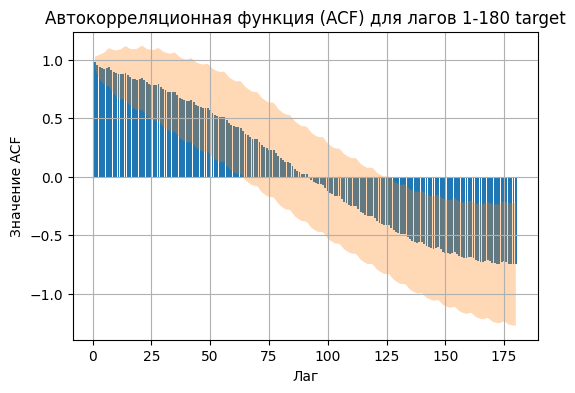

[180]
Первые 3 номера лагов со значимой автокорреляцией: [1, 2, 3]
Последние 5 номеров лагов со значимой автокорреляцией: [176, 177, 178, 179, 180]


In [ ]:
acf, confint = sm.tsa.acf(df_day['target'], nlags=180, alpha=0.05)
lags = range(1, 181)

# Построим график ACF
plt.figure(figsize=(6, 4))
plt.bar(lags, acf[1:])
plt.title('Автокорреляционная функция (ACF) для лагов 1-180 target')
plt.xlabel('Лаг')
plt.ylabel('Значение ACF')
plt.grid(True)

# Добавим доверительный интервал
plt.fill_between(lags, confint[1:, 0], confint[1:, 1], alpha=0.3)

plt.show()

# Найдем номера лагов с значимой автокорреляцией
significant_lags_meta = [lag for lag, (lower, upper) in zip(lags, confint[1:]) if lower > 0 or upper < 0]
meta_lags = significant_lags_meta[-1:]
print(meta_lags)

# Выведем только первые 3 и последние 3 значения
print("Первые 3 номера лагов со значимой автокорреляцией:", significant_lags_meta[:3])
print("Последние 5 номеров лагов со значимой автокорреляцией:", significant_lags_meta[-5:])

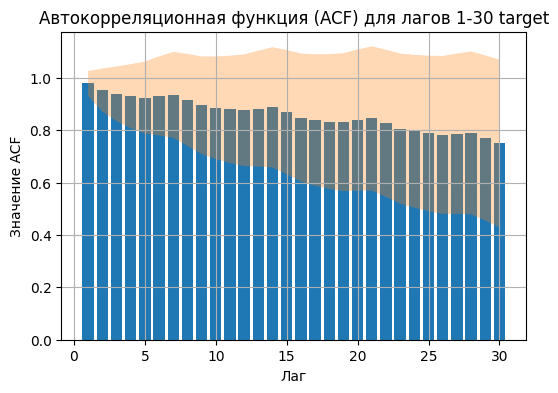

[30]
Первые 3 номера лагов со значимой автокорреляцией: [1, 2, 3]
Последние 5 номеров лагов со значимой автокорреляцией: [26, 27, 28, 29, 30]


In [ ]:
acf, confint = sm.tsa.acf(df_day['target'], nlags=30, alpha=0.05)
lags = range(1, 31)

# Построим график ACF
plt.figure(figsize=(6, 4))
plt.bar(lags, acf[1:])
plt.title('Автокорреляционная функция (ACF) для лагов 1-30 target')
plt.xlabel('Лаг')
plt.ylabel('Значение ACF')
plt.grid(True)

# Добавим доверительный интервал
plt.fill_between(lags, confint[1:, 0], confint[1:, 1], alpha=0.3)

plt.show()

# Найдем номера лагов с значимой автокорреляцией
significant_lags_meta = [lag for lag, (lower, upper) in zip(lags, confint[1:]) if lower > 0 or upper < 0]
meta_lags = significant_lags_meta[-1:]
print(meta_lags)

# Выведем только первые 3 и последние 3 значения
print("Первые 3 номера лагов со значимой автокорреляцией:", significant_lags_meta[:3])
print("Последние 5 номеров лагов со значимой автокорреляцией:", significant_lags_meta[-5:])

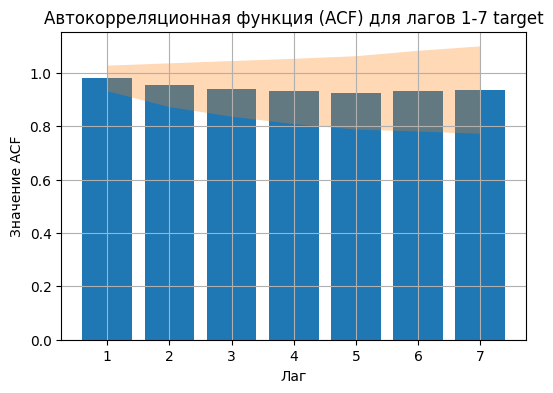

[7]
Первые 3 номера лагов со значимой автокорреляцией: [1, 2, 3]
Последние 5 номеров лагов со значимой автокорреляцией: [3, 4, 5, 6, 7]


In [ ]:
acf, confint = sm.tsa.acf(df_day['target'], nlags=7, alpha=0.05)
lags = range(1, 8)

# Построим график ACF
plt.figure(figsize=(6, 4))
plt.bar(lags, acf[1:])
plt.title('Автокорреляционная функция (ACF) для лагов 1-7 target')
plt.xlabel('Лаг')
plt.ylabel('Значение ACF')
plt.grid(True)

# Добавим доверительный интервал
plt.fill_between(lags, confint[1:, 0], confint[1:, 1], alpha=0.3)

plt.show()

# Найдем номера лагов с значимой автокорреляцией
significant_lags_meta = [lag for lag, (lower, upper) in zip(lags, confint[1:]) if lower > 0 or upper < 0]
meta_lags = significant_lags_meta[-1:]
print(meta_lags)

# Выведем только первые 3 и последние 3 значения
print("Первые 3 номера лагов со значимой автокорреляцией:", significant_lags_meta[:3])
print("Последние 5 номеров лагов со значимой автокорреляцией:", significant_lags_meta[-5:])

## Summary

<span style="color:blue">

---
* Годовых трендов у потребления электроэнергии не наблюдается.
* Есть годовые, недельные и суточные циклы. Так, энергопотребление увеличивается по сезонам в следующем порядке: лето, весно, осень, зима. В будние дни энергопотребление выше, чем в выходные. Внутри дня энергпотребление больше в дневные и вечерние часы.
* Потребление электроэнергии имеет сильную отрицательную корреляционную связь с температурой и прогнозом температуры.
* Прогнозная температура имеет немного больший коэффициент корреляции с потреблением электроэнергии, чем фактическая. В среднем прогноз не соответствует факту на 2°С.

---
</span>
